# Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

In [3]:

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


# Dataset

In [4]:
import jetnet
from jetnet.datasets import JetNet
from jetnet.datasets.normalisations import FeaturewiseLinearBounded, FeaturewiseLinear

/Users/arjunsharma/development/s25-fermilab-research/venv/lib/python3.12/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [5]:
MASK = True
NUM_PARTICLES = 30
TRAIN_SPLIT = 0.7

In [6]:

feature_maxes = JetNet.fpnd_norm.feature_maxes
if MASK:
    feature_maxes = feature_maxes + [1]
particle_normalizer = FeaturewiseLinearBounded(
    feature_norms=1.0,
    feature_shifts=[0.0, 0.0, -0.5, -0.5] if MASK else [0.0, 0.0, -0.5],
    feature_maxes=feature_maxes, # Max pre-scaling values of each feature
)

FeaturewiseLinear(feature_scales=(1/NUM_PARTICLES))

data_args = {
    # Gluons, light quarks, and top quarks
    "jet_type": ["g", "q", "t"],
    "data_dir": "datasets/jetnet",
    "num_particles": NUM_PARTICLES,
    "particle_features": (
        JetNet.ALL_PARTICLE_FEATURES if MASK else JetNet.ALL_PARTICLE_FEATURES[:-1]
    ),
    # Unlike MPGAN, retrieve jet-level info for conditioning
    "jet_features": ["type", "pt", "eta", "mass", "num_particles"],
    "particle_normalisation": particle_normalizer,
    "split_fraction": [TRAIN_SPLIT, 1 - TRAIN_SPLIT, 0],
    "download": True
}

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128
X_train = JetNet(**data_args, split="train")
X_train_loaded = DataLoader(X_train, shuffle=True, batch_size=BATCH_SIZE, pin_memory=True)

X_test = JetNet(**data_args, split="valid")
X_test_loaded = DataLoader(X_test, batch_size=BATCH_SIZE, pin_memory=True)

In [8]:
len(X_train)

368113

In [9]:
X_train[0][0].shape

torch.Size([30, 4])

In [10]:
X_train[0][1].shape

torch.Size([5])

`X_train` consists of 616,000 jets; each of which is represented as a tuple with 2 elements:
1. A shape `30 x 4` tensor representing each of the particles in the jet, where the features are in the order of ['etarel', 'phirel', 'ptrel', 'mask']
2. A length `5` tensor consisting of jet features ["type", "pt", "eta", "mass", "num_particles"]

In [11]:
type(X_train)

jetnet.datasets.jetnet.JetNet

/Users/arjunsharma/development/s25-fermilab-research/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


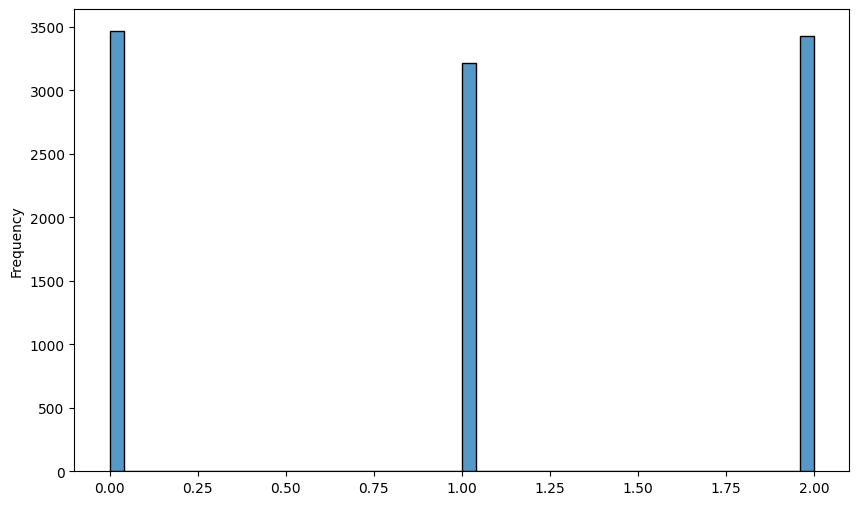

In [12]:
N_SAMPLES = 10_000

type_vals = []
for i, (particles, jets) in enumerate(X_train_loaded):
    if i * BATCH_SIZE >= N_SAMPLES:
        break
    type_vals.extend(jets[:, 0].cpu().numpy())

plt.figure(figsize=(10, 6))
sns.histplot(type_vals, bins=50)
plt.ylabel("Frequency")
plt.show()


In [13]:
import pandas as pd
pd.Series(type_vals).describe()

count    10112.000000
mean         0.996341
std          0.825663
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          2.000000
dtype: float64

## Model

In [14]:
from models.LorentzNet import LGEB